# Planetary Boundary Layer (PBL) Height Retrievals from Ceilometer Data

## Imports

In [24]:
import pywt
import numpy as np
import cmweather
import xarray as xr
import scipy
import act
import pywt
import glob
import matplotlib.pyplot as plt

## Data Access

Data has been pre-staged to the local directory, it can be found on [ESS-Dive](https://data.ess-dive.lbl.gov/submit/ess-dive-c529c777285ecc3-20240419T182555711)

In [25]:
base_dir = "/Users/mgrover/crocus-data/daily-cl61/"

In [26]:
files = sorted(glob.glob(f"{base_dir}crocus-neiu-ceil-a1-20230607*.nc"))

In [27]:
ds = xr.open_dataset(files[-1])

In [28]:
import act

In [29]:
ds = ds.sel(range=slice(0, 3000))
ds = ds.interp(range=np.arange(50, 3000, 50), method='nearest')

In [30]:
ds

<xarray.Dataset> Size: 1MB
Dimensions:                            (time: 799, layer: 5, range: 59)
Coordinates:
  * time                               (time) datetime64[ns] 6kB 2023-06-07T0...
  * layer                              (layer) float64 40B 1.0 2.0 3.0 4.0 5.0
    longitude                          float64 8B -87.72
    latitude                           float64 8B 41.98
  * range                              (range) int64 472B 50 100 ... 2900 2950
Data variables: (12/26)
    cloud_base_heights                 (time, layer) float64 32kB 4.032e+03 ....
    vertical_visibility                (time) float64 6kB nan nan ... nan nan
    p_pol                              (time, range) float32 189kB 9.67e-07 ....
    x_pol                              (time, range) float32 189kB 3.927e-08 ...
    beta_att                           (time, range) float32 189kB 1.006e-06 ...
    linear_depol_ratio                 (time, range) float32 189kB 0.03625 .....
    ...                                 ...
    fog_detection                      (time) float32 3kB 0.0 0.0 ... 0.0 0.0
    receiver_gain                      (time) float32 3kB 1.0 1.0 ... 1.0 1.0
    range_resolution                   (time) float32 3kB 4.8 4.8 ... 4.8 4.8
    cloud_calibration_factor           (time) float64 6kB 0.4334 ... 0.4334
    cloud_calibration_factor_user      (time) float64 6kB 0.4334 ... 0.4334
    overlap_function                   (time, range) float32 189kB 0.07701 .....
Attributes: (12/14)
    title:                          CL61D CL61 with Depolarization
    institution:                    NEIU
    source:                         
    conventions:                    CF-1.8
    schema_version:                 1.3
    sw_version:                     1.2.7
    ...                             ...
    unit:                           m
    instrument_serial_number:       U3810828
    overlap_function_provided:      1
    overlap_is_corrected:           1
    file_temporal_span_in_minutes:  5.0
    profile_interval_in_seconds:    60

In [31]:
ds = act.corrections.correct_ceil(ds, var_name="beta_att")
ds = act.corrections.correct_ceil(ds, var_name="x_pol")
ds = act.corrections.correct_ceil(ds, var_name="p_pol")

In [32]:
ds["beta_att"] = ds.beta_att.where(ds.beta_att >= -6.5)

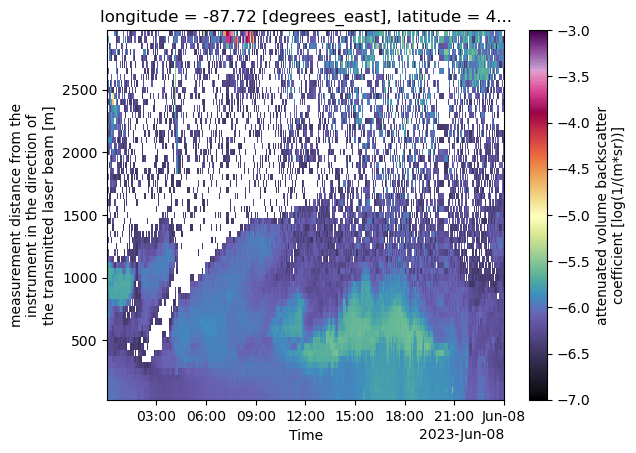

In [33]:
ds.beta_att.plot(x='time', vmin=-7, vmax=-3, cmap='ChaseSpectral')

In [34]:
coeffs = pywt.dwt2(ds.beta_att.values, 'haar')
cA, (cH, cV, cD) = coeffs

resampled_range = ds.range.values[::2]
resampled_time = ds.time.values[::2]

ds["resampled_range"] = resampled_range
ds["resampled_time"] = resampled_time

ds = ds.set_coords(["resampled_range", "resampled_time"])

ds["wavelet_backscatter"] = (("resampled_time", "resampled_range"), cA) 


min_range = ds.wavelet_backscatter.min("resampled_range")
pbl_heights = []
for time in range(len(ds.resampled_time)):
    ds_single_time = ds.isel(resampled_time=time).wavelet_backscatter
    pbl_heights.append(ds_single_time.where(ds_single_time == min_range.isel(resampled_time=time), drop=True).resampled_range.values[0])

ds["pbl_height"] = (("resampled_time"), pbl_heights)

ds["pbl_height"] = ds.pbl_height.where(ds.pbl_height < 3000)

mask = (ds.linear_depol_ratio > 0) & (ds.linear_depol_ratio <=0.7)
ldr = ds.linear_depol_ratio.where(mask)
back = ds.beta_att.where(mask)

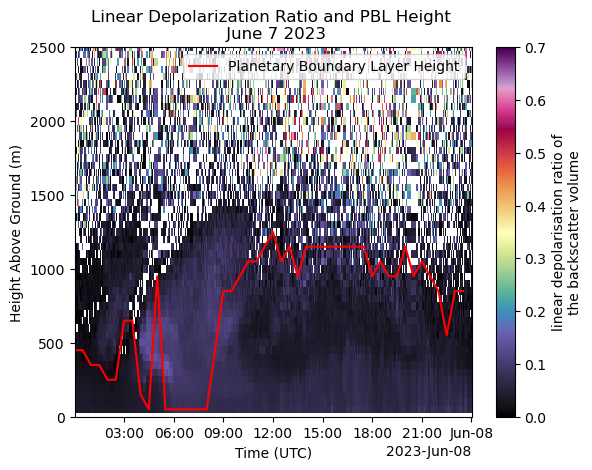

In [35]:
ldr.plot(x='time', vmin=0, vmax=.7, cmap='ChaseSpectral')
ds.pbl_height.resample(resampled_time='30min').min().plot(color='r', label='Planetary Boundary Layer Height')
plt.ylim(0, 2_500)
plt.legend(loc='upper right')
plt.ylabel("Height Above Ground (m)")
plt.xlabel("Time (UTC)")
plt.title("Linear Depolarization Ratio and PBL Height \n June 7 2023")
plt.savefig("ldr_pbl_june_7_2023.png", dpi=300)

In [36]:
ds["pbl_height"] = ds.pbl_height.interp(resampled_time=ds.time)

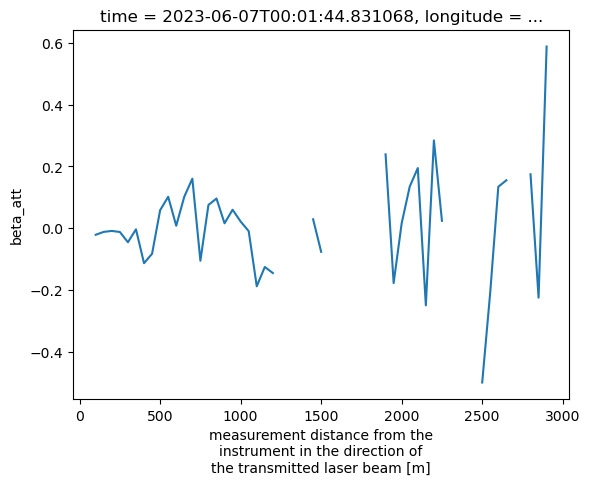

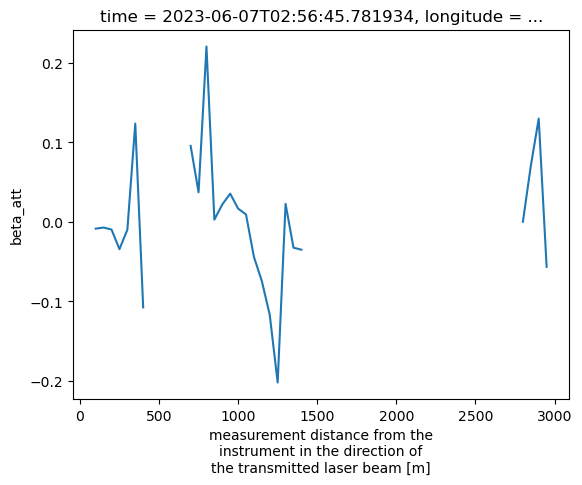

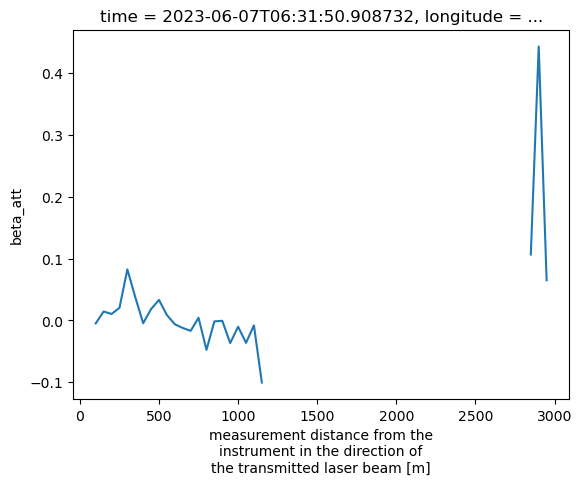

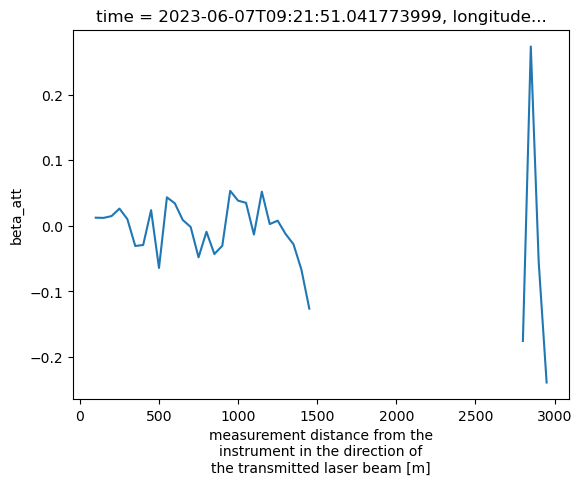

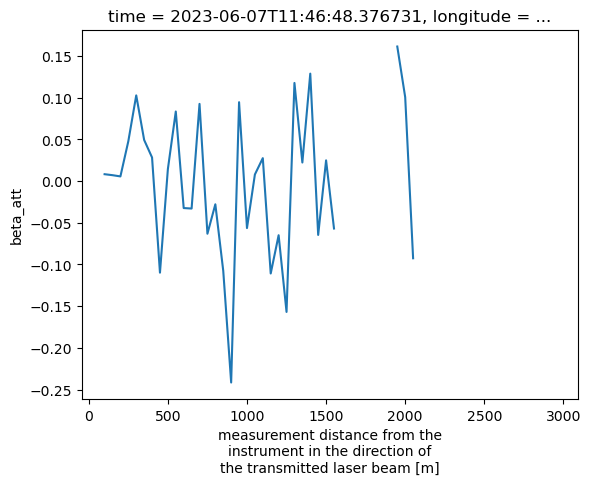

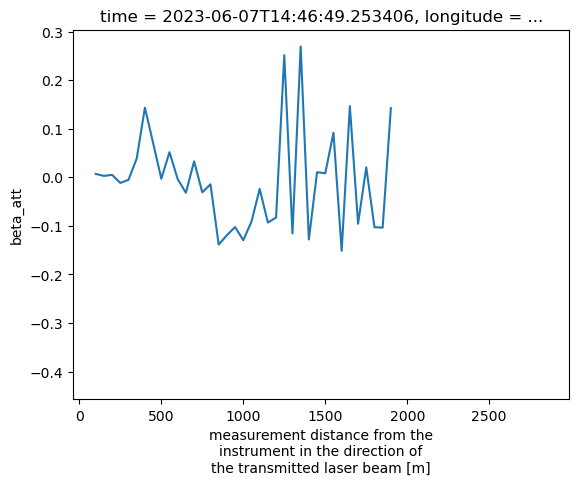

In [37]:
for i in range(0, 600, 100):
    #ds.beta_att.isel(time=i).plot(label=f'time step {i}')
    ds.beta_att.isel(time=i).diff("range").plot(label=f'time step {i}')
    plt.show()
    plt.close()

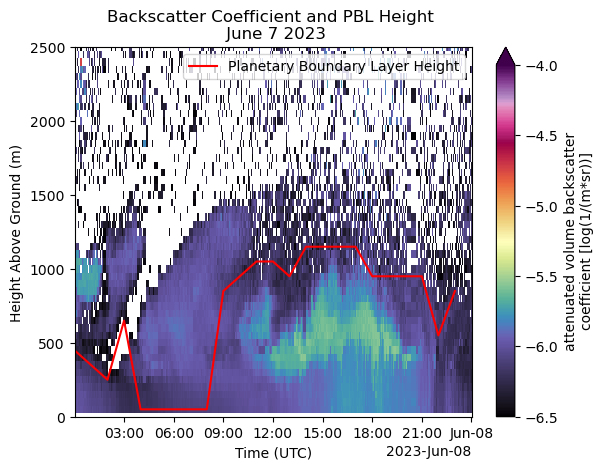

In [39]:
back.plot(x='time', vmin=-6.5, vmax=-4, cmap='ChaseSpectral')
ds.pbl_height.resample(time='60min').min().plot(color='r', label='Planetary Boundary Layer Height')
plt.ylim(0, 2_500)
plt.legend(loc='upper right')
plt.ylabel("Height Above Ground (m)")
plt.xlabel("Time (UTC)")
plt.title("Backscatter Coefficient and PBL Height \n June 7 2023")
plt.savefig("backscatter_pbl_june_7_2023.png", dpi=300)

In [40]:
ds = xr.open_dataset(f"{base_dir}crocus-neiu-ceil-a1-20230725-000000.nc")

ds = ds.sel(range=slice(0, 4_500))

ds = act.corrections.correct_ceil(ds, var_name="beta_att")

ds["beta_att"] = ds.beta_att.where(ds.beta_att >= -6.5)

In [41]:
coeffs = pywt.dwt2(ds.beta_att.values, 'haar')
cA, (cH, cV, cD) = coeffs

resampled_range = ds.range.values[::2]
resampled_time = ds.time.values[::2]

ds["resampled_range"] = resampled_range
ds["resampled_time"] = resampled_time

ds = ds.set_coords(["resampled_range", "resampled_time"])

ds["wavelet_backscatter"] = (("resampled_time", "resampled_range"), cA) 


min_range = ds.wavelet_backscatter.diff("resampled_range").max("resampled_range")
pbl_heights = []
for time in range(len(ds.resampled_time)):
    ds_single_time = ds.isel(resampled_time=time).wavelet_backscatter
    pbl_heights.append(ds_single_time.where(ds_single_time.diff("resampled_range") == min_range.isel(resampled_time=time), drop=True).resampled_range.values[0])

ds["pbl_height"] = (("resampled_time"), pbl_heights)

ds["pbl_height"] = ds.pbl_height.where(ds.pbl_height < 3000)

mask = (ds.linear_depol_ratio > 0) #& (ds.linear_depol_ratio <=0.7)
ldr = ds.linear_depol_ratio#.where(mask)
back = ds.beta_att#.where(mask)

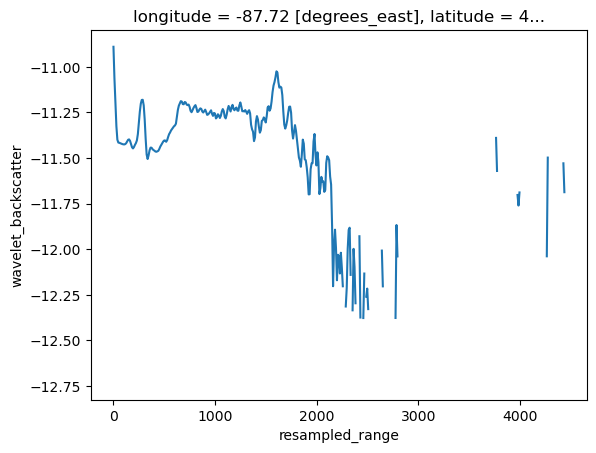

In [42]:
ds.isel(resampled_time=0).wavelet_backscatter.plot()


In [43]:
ds.receiver_gain

<xarray.DataArray 'receiver_gain' (time: 815)> Size: 3kB
[815 values with dtype=float32]
Coordinates:
  * time       (time) datetime64[ns] 7kB 2023-07-25T00:00:39.740011999 ... 20...
    longitude  float64 8B ...
    latitude   float64 8B ...
Attributes:
    long_name:  receiver gain status
    comment:    high-gain/low-gain (1/0)

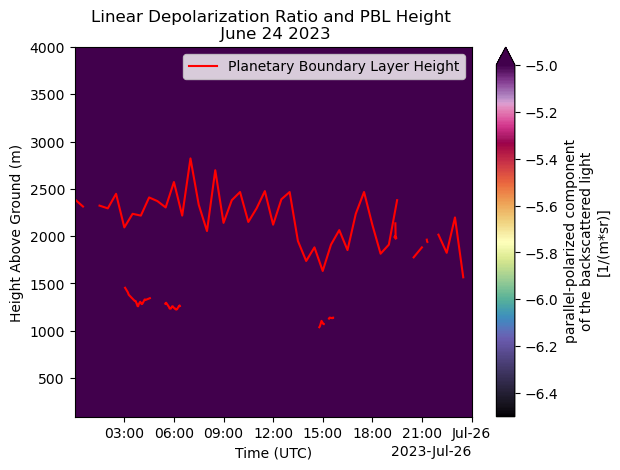

In [44]:
ds.p_pol.plot(x='time', vmin=-6.5, vmax=-5, cmap='ChaseSpectral')
ds.pbl_height.resample(resampled_time='30min').min().plot(color='r', label='Planetary Boundary Layer Height')
ds.cloud_base_heights.isel(layer=0).plot(color='r')
plt.ylim(90, 4000)
plt.legend(loc='upper right')
plt.ylabel("Height Above Ground (m)")
plt.xlabel("Time (UTC)")
plt.title("Linear Depolarization Ratio and PBL Height \n June 24 2023")
plt.savefig("co_pol_pbl_july_25_2023.png", dpi=300)

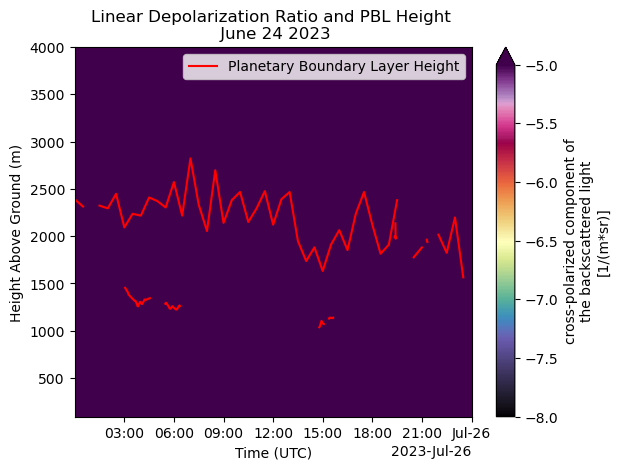

In [45]:
ds.x_pol.plot(x='time', vmin=-8, vmax=-5, cmap='ChaseSpectral')
ds.pbl_height.resample(resampled_time='30min').min().plot(color='r', label='Planetary Boundary Layer Height')
ds.cloud_base_heights.isel(layer=0).plot(color='r')
plt.ylim(90, 4000)
plt.legend(loc='upper right')
plt.ylabel("Height Above Ground (m)")
plt.xlabel("Time (UTC)")
plt.title("Linear Depolarization Ratio and PBL Height \n June 24 2023")
plt.savefig("cross_pol_pbl_july_25_2023.png", dpi=300)

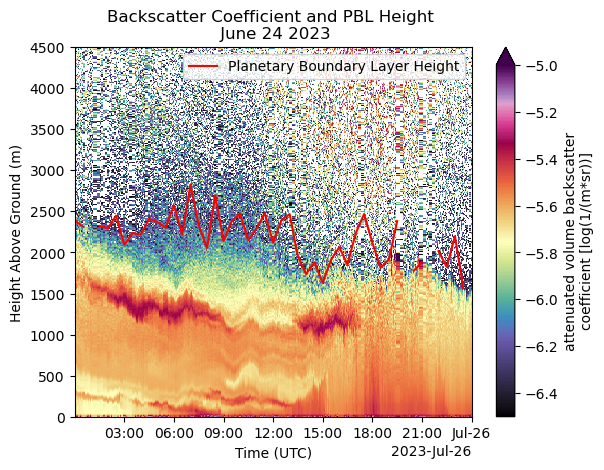

In [46]:
back.plot(x='time', vmin=-6.5, vmax=-5, cmap='ChaseSpectral')
ds.pbl_height.resample(resampled_time='30min').min().plot(color='r', label='Planetary Boundary Layer Height')

plt.ylim(0, 4_500)
plt.legend(loc='upper right')
plt.ylabel("Height Above Ground (m)")
plt.xlabel("Time (UTC)")
plt.title("Backscatter Coefficient and PBL Height \n June 24 2023")
plt.savefig("backscatter_pbl_july_25_2023.png", dpi=300)

In [616]:
files = sorted(glob.glob("../../crocus/mrr-quicklooks/20230725/*"))

mrr_ds = xr.open_mfdataset(files,
                           concat_dim='time',
                           combine="nested")

mrr_ds = mrr_ds.sortby("time")

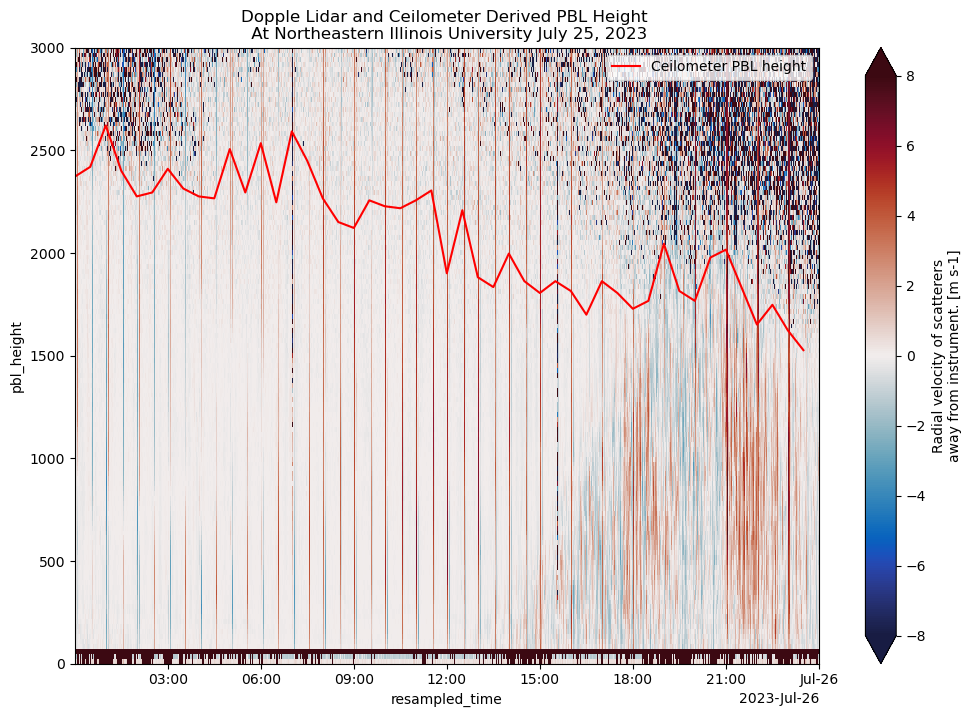

In [620]:
fig = plt.figure(figsize=(12,8))
mrr_ds.sel(range=slice(0, 3_000)).radial_velocity.plot(x='time',
                                                       vmin=-8,
                                                       cmap='balance',
                                                       vmax=8)
ds.pbl_height.resample(resampled_time='30min').min().plot(color='r', label='Ceilometer PBL height')
plt.legend(loc="upper right")
plt.title("Dopple Lidar and Ceilometer Derived PBL Height \n At Northeastern Illinois University July 25, 2023")
plt.savefig("doppler_velocity_july_25_2023.png", dpi=300)

---

## MRR Section

In [460]:
import pyart


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [513]:
import glob

In [514]:
files = sorted(glob.glob("../../crocus/mrr-quicklooks/20230624/*"))

In [471]:
mrr_ds = xr.open_mfdataset(files,
                           concat_dim='time',
                           combine="nested")

mrr_ds = mrr_ds.sortby("time")

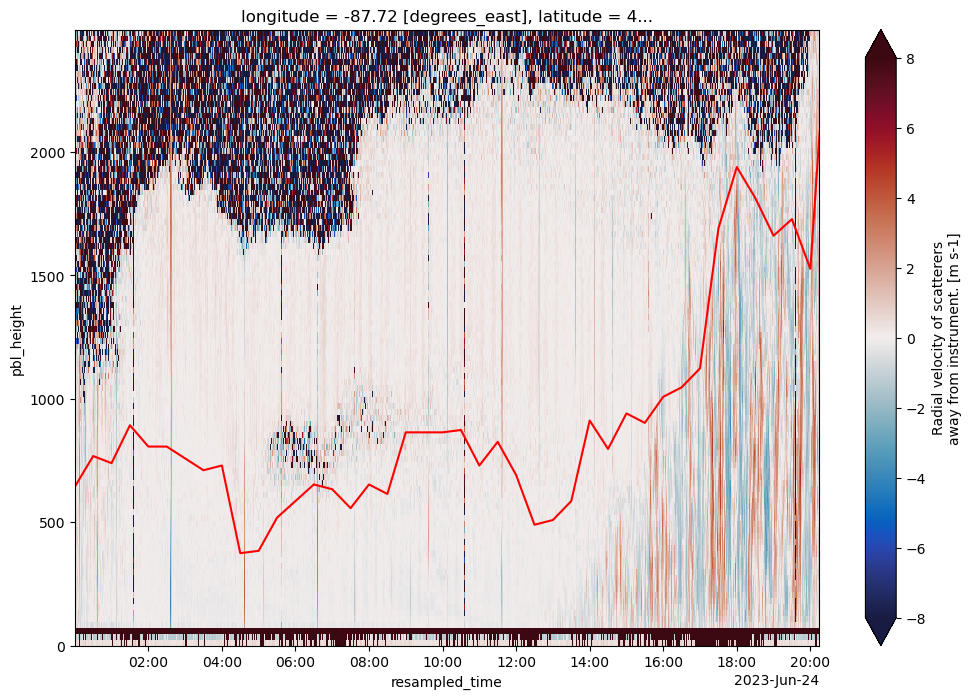

In [479]:
fig = plt.figure(figsize=(12,8))
mrr_ds.sel(range=slice(0, 2_500)).radial_velocity.plot(x='time',
                                                       vmin=-8,
                                                       cmap='balance',
                                                       vmax=8)
ds.pbl_height.resample(resampled_time='30min').min().plot(color='r', label='Ceilometer PBL height')